# Regressor Chain

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from notebook_utils import scores_barplot, print_avg_scores, mo_reg_scorer,\
     scale_split_labels, split_train_test
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from ChainRegressor import ChainRegressor


pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)
sns.set_theme(style="whitegrid")

## Import & Prepare Data

In [2]:
# Load dataset from csv
data = pd.read_csv("..\\data\\dataset-merged.csv")

# Drop unwanted columns
data.drop(['sheepid'], axis=1, inplace=True)
data.drop(['slaughgr'], axis=1, inplace=True)
data.drop(['sex'], axis=1, inplace=True)
data.drop(['breed'], axis=1, inplace=True)

print(data.head())

   slweight(g)  woolfr  blood  feet  pelt  fullGI  mesent  epipl  liver  spleen  pluck  head  warmcarc  kidney  KKCF  tail  coldcarc  mw%  WtBefDIS  LEG  CHUMP  LOIN  BREAST  BESTEND  MIDNECK  SHOULDER  NECK
0        12399     150    575   450  1250    1400     100    150    275      30    425   635      6850      32   122    32      6612   25      3280  820    307   336     323      236      477       665   110
1        12500     130    575   475  1245    1500      75     75    300      50    525   650      6800      32    78    32      6542   25      3180  803    298   322     290      242      454       682    94
2        12300     140    600   475  1200    1300     100    125    275      50    400   625      6875      32   118    44      6776   25      3350  812    350   328     316      238      500       670   130
3        12399     120    625   450  1225    1375     125    250    300      50    400   650      6850      34   154    32      6642   25      3290  846    274   358   

In [3]:
# Separate labels and split to train, test sets
X, y = scale_split_labels(data)
X_train, X_test, y_train, y_test = split_train_test(X, y)

## Linear Regression Random Chain
Αρχικά, θα μετρήσουμε την απόδοση ενός chain regressor με χρήση αποκλειστικά Linear Regression μοντέλου και τυχαία σειρά
στη πρόβλεψη των μεταβλητών, προκειμένου να πάρουμε κάποιες baseline μετρήσεις.

Linear Regression Random Chain
R2 score: 0.8271968148229819
MAE: 0.2351750171075201
RMSE: 0.3086577502857589
MAPE: 1.551649626343733



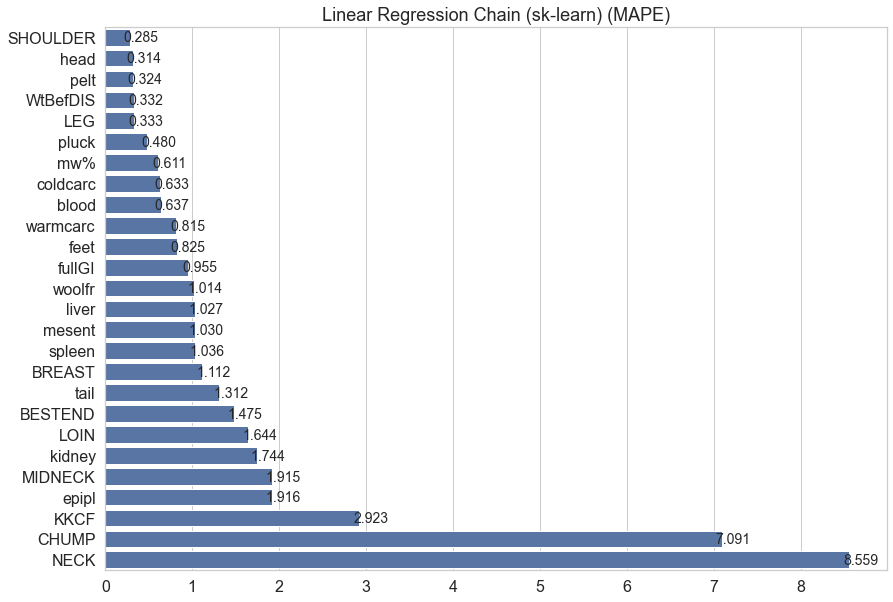

In [4]:
# Try scikit-learn chain regressor with linear regression base model & random chain order
mod = RegressorChain(LinearRegression(), order='random', random_state=96)
mod.fit(X_train, y_train)
lr_scores = mo_reg_scorer(mod, X_test, y_test)
print_avg_scores(lr_scores, 'Linear Regression Random Chain')
scores_barplot(lr_scores['rv_scores_mape'], y_test.columns, title='Linear Regression Chain (sk-learn) (MAPE)')

Συγκριτικά με την επίδοση του Linear Regression χωρίς chain meta-regressor που είδαμε στο Notebook "EDA_notebook" ο
Chain Linear Regression έχει ακριβώς το ίδιο σφάλμα σε όλες τις μεταβλητές. (??)

## XGBoost
Επίσης, θα μετρήσουμε την απόδοση ενός chain regressor με χρήση αποκλειστικά XGBoost μοντέλου και τυχαία σειρά
στη πρόβλεψη των μεταβλητών, προκειμένου να πάρουμε μερικές ακόμα baseline μετρήσεις.

XGBoost Random Chain
R2 score: 0.8518696453728822
MAE: 0.21379560605893003
RMSE: 0.28435847416432314
MAPE: 1.2398508001381323



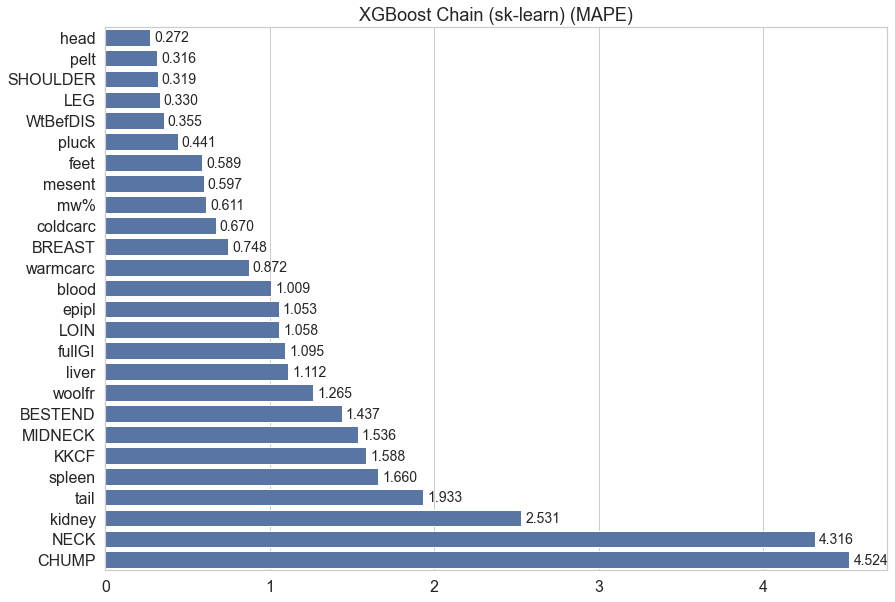

In [5]:
# Try scikit-learn chain regressor with XGBoost base model & random chain order
mod = RegressorChain(xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1,
                                      max_depth=3, n_estimators=100, n_jobs=-1), order='random', random_state=96)
mod.fit(X_train, y_train)
xgb_scores = mo_reg_scorer(mod, X_test, y_test)
print_avg_scores(xgb_scores, 'XGBoost Random Chain')
scores_barplot(xgb_scores['rv_scores_mape'], y_test.columns, title='XGBoost Chain (sk-learn) (MAPE)')

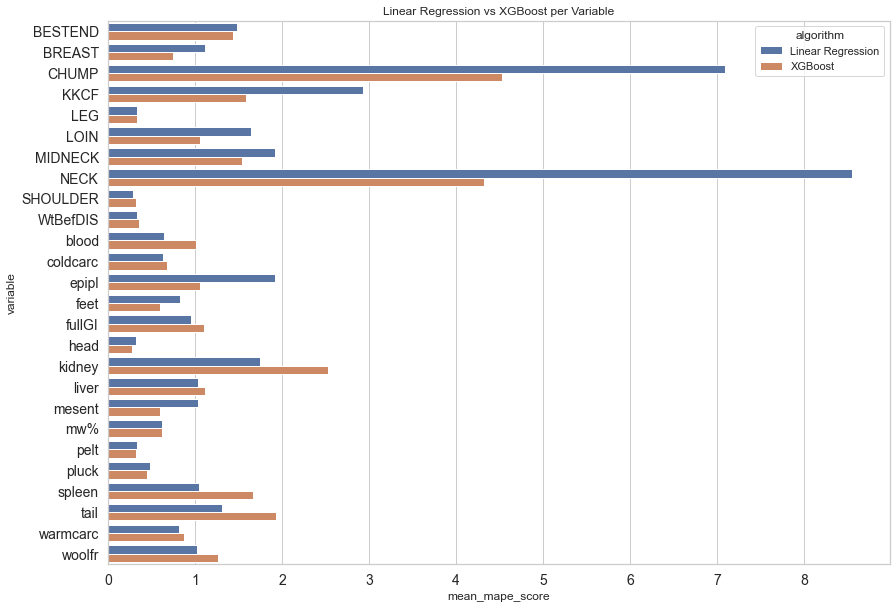

In [6]:
import matplotlib.pyplot as plt

d = {
    'variable': np.append(y_test.columns.to_numpy(), y_test.columns.to_numpy()),
    'score': np.append(lr_scores['rv_scores_mape'], xgb_scores['rv_scores_mape']),
    'algorithm': np.append(np.full(26, 'Linear Regression'), np.full(26, 'XGBoost'))
}

comp_df = pd.DataFrame(columns=['variable', 'score', 'algorithm'], data=d)
comp_df = comp_df.groupby(['variable', 'algorithm']).agg(mean_mape_score=('score', 'mean'))
comp_df = comp_df.reset_index()
# print(comp_df)

plt.figure(figsize=(14, 10))
plt.title('Linear Regression vs XGBoost per Variable')
comp_bp = sns.barplot(y='variable',
            x='mean_mape_score',
            hue='algorithm',
            orient='h',
            data= comp_df
)
comp_bp.tick_params(labelsize=14)

Συγκριτικά με την επίδοση του Linear Regression χωρίς chain meta-regressor που είδαμε στο Notebook "EDA_notebook" ο
Chain XGBoost έχει μειωμένο MAPE ακόμα και με χρήση τυχαίας σειράς των μεταβλητών.

## Custom Regressor Chain
Στη συνέχεια, θα κατασκευάσουμε έναν custom chain regressor ο οποίος επιτρέπει τη χρήση διαφορετικών μοντέλων σε κάθε
στάδιο της αλυσίδας με σκόπο να τη βελτίωση των αποτελεσμάτων.

* Γνωρίζουμε ότι τα χαρ/κα WtBefDIS, warmcarc και coldcarc είναι γραμμικά εξαρτημένα απο το χαρ/κο slweight και έχουν υψηλή
συσχέτιση με αυτό όπως είδαμε. Επίσης, όπως είδαμε και στο EDA_notebook, τα τρία αυτά χαρ/κά συμμετέχουν και είναι
σημαντικά για τη πρόβλεψη των υπολοιπων εξαρτημένων μεταβλητών. Επομένως, θα ξεκινήσουμε την αλυσίδα προβλέποντας αυτά
τα χαρ/κα.

* Στη συνέχεια, θα κατασκευάσουμε έναν custom chain regressor με βάση τα feature importances των μεταβλητών.

Custom Chain Regressor Based on Feature Importances #1
R2 score: 0.8307288652788276
MAE: 0.21426754453683872
RMSE: 0.29946093165147303
MAPE: 1.2536908384054537



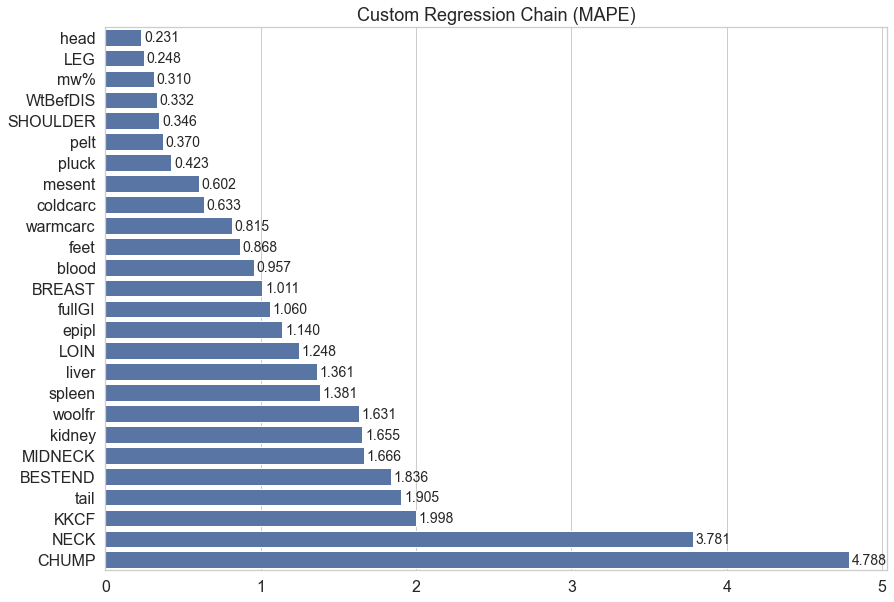

In [7]:
xgb_reg = xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=90, n_jobs=-1)

chain_links_1 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),
    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'KKCF']),
    (MultiOutputRegressor(xgb_reg), ['LEG', 'BREAST', 'BESTEND']),
    (MultiOutputRegressor(xgb_reg), ['CHUMP', 'woolfr', 'MIDNECK', 'pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'NECK', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['pluck', 'LOIN', 'head', 'tail']),
    (MultiOutputRegressor(xgb_reg), ['feet', 'blood', 'spleen']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['mw%']),
]

# Run Chain Regressor & show results
chain_reg = ChainRegressor(chain_links_1)
clinks = chain_reg.fit(X_train, y_train)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print_avg_scores(scores, 'Custom Chain Regressor Based on Feature Importances #1')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Custom Regression Chain (MAPE)')

* O custom regressor με σειρά πρόβλεψης με βάση τα feature importances δίνει μικρότερο σφάλμα σε σχέτιση με τους
baseline random chain regressors.

* Τα χαρ/κα 'epipl', 'mesent', 'KKCF' και 'mw%' παρατηρούμε πως σύμφωνα με τα feature importances του XGBoost είναι
σημαντικά μόνο μεταξύ τους και δεν επηρρεάζονται ιδιαίτερα απο τα υπόλοιπα χαρακτηριστικά. Ωστόσο, σύμφωνα με τα feature
importances του Linear Regression επηρρεάζονται κυρίως απο τα χαρακτηριστικά 'slweight', 'warmcarc', 'coldcar' και
'WtBefDIS'. Για αυτό το λόγο θα βάζουμε τη πρόβλεψή των χαρακτηριστικών αυτών αμέσως μετά τη πρόβλεψη των
'slweight', 'warmcarc', 'coldcar' και 'WtBefDIS' με εξαίρεση το 'mw%', το οποίο σύμφωνα και πάλι με τα feature
importances του Linear Regression επηρεάζεται απο τις περισσότερες υπόλοιπες μεταβλητές έστω και απο λίγο και απομένως
θα μπεί τελευταίο στη σειρά.

### Ιδιαιτερότητες Χαρακτηριστικών 'epipl', 'mesent', 'KKCF' και 'mw%'
Παρακάτω παρατηρούμε πως άν αφήσουμε τη πρόβλεψη των χαρακτηριστικών 'epipl', 'mesent', 'KKCF' και 'mw%' για το τέλος,
παρότι το σφάλμα τους αυξάνεται, το σφάλμα σχεδόν όλων των υπολοίπων μεταβλητών μειώνεται με αποτέλεσμα τη μείωση του
μέσου σφάλματος.

Custom Chain Regressor Based on Feature Importances #2
R2 score: 0.8174862144094408
MAE: 0.2209956415615005
RMSE: 0.31109331354008496
MAPE: 1.2297793096903773



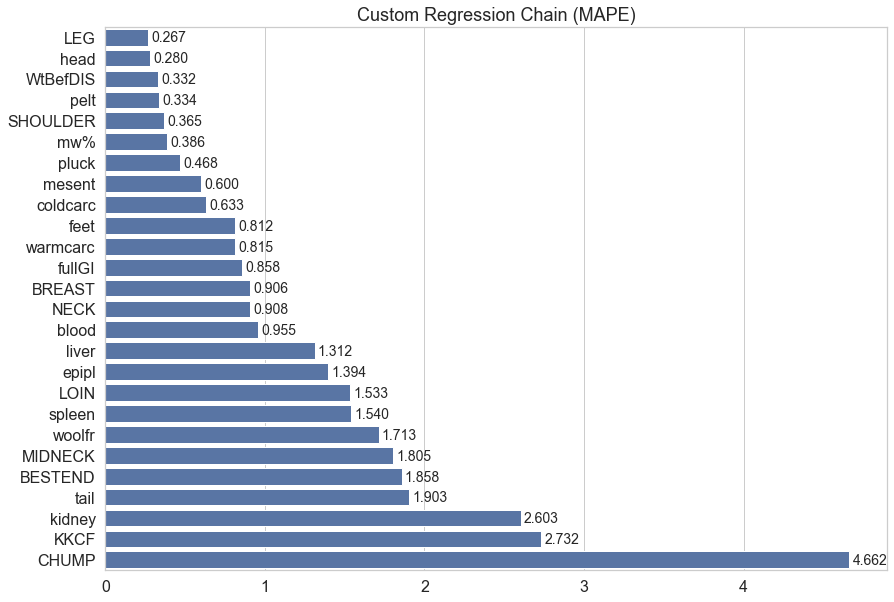

In [8]:
chain_links_2 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),
    (MultiOutputRegressor(xgb_reg), ['LEG', 'BREAST', 'BESTEND']),
    (MultiOutputRegressor(xgb_reg), ['CHUMP', 'woolfr', 'MIDNECK', 'pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'NECK', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['pluck', 'LOIN', 'head', 'tail']),
    (MultiOutputRegressor(xgb_reg), ['feet', 'blood', 'spleen']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'KKCF', 'mw%']),
]

# Run Chain Regressor & show results
chain_reg = ChainRegressor(chain_links_2)
clinks = chain_reg.fit(X_train, y_train)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print_avg_scores(scores, 'Custom Chain Regressor Based on Feature Importances #2')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Custom Regression Chain (MAPE)')

### Μη-σημαντικά Χαρακτηριστικά
Στο προηγούμενο Notebook παρατηρήσαμε πως κάποια χαρακτηριστικά δέν είναι σχεδόν καθόλου σημαντικά για κανένα χαρ/κο. 
Με βάση αυτή τη παρατήρηση θα δοκιμάσουμε να αφήσουμε τη πρόβλεψη αυτών των χαρακτηριστικών για το τέλος της αλυσίδας
μήπως και μειώσουμε το σφάλμα.

Custom Chain Regressor Based on Feature Importances #3
R2 score: 0.8130833337317024
MAE: 0.22045806240851112
RMSE: 0.31348422914207724
MAPE: 1.2608629626317895



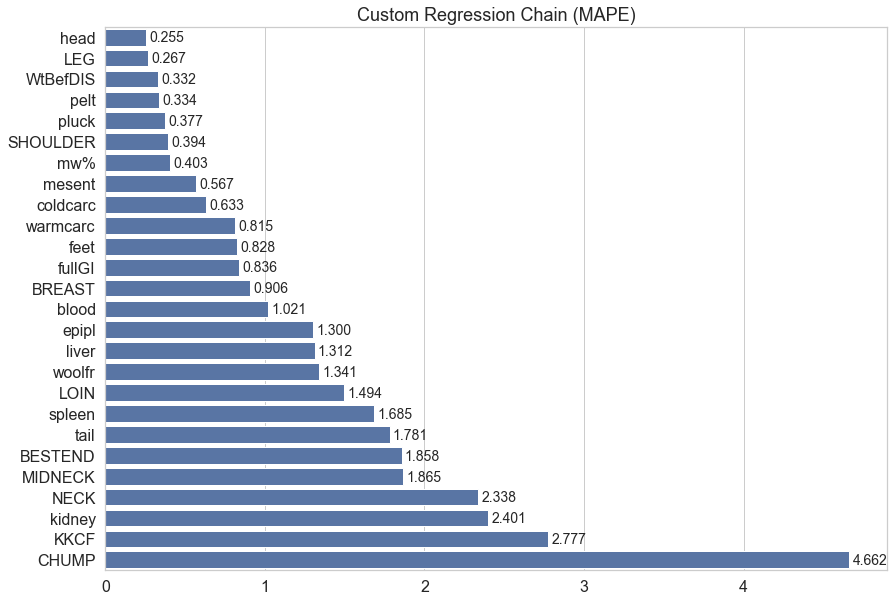

In [9]:
chain_links_3 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),
    (MultiOutputRegressor(xgb_reg), ['LEG', 'BREAST', 'BESTEND']),
    (MultiOutputRegressor(xgb_reg), ['CHUMP', 'pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['pluck', 'LOIN']),
    (MultiOutputRegressor(xgb_reg), ['feet']),
    (MultiOutputRegressor(xgb_reg), ['woolfr', 'blood', 'spleen', 'head', 'tail', 'MIDNECK', 'NECK']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'KKCF', 'mw%']),
]

# Run Chain Regressor & show results
chain_reg = ChainRegressor(chain_links_3)
clinks = chain_reg.fit(X_train, y_train)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print_avg_scores(scores, 'Custom Chain Regressor Based on Feature Importances #3')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Custom Regression Chain (MAPE)')

* Το μέσο σφάλμα αυξήθηκε.
* Το σφάλμα των μεταβλητών head, pluck, mesent, epipl, LOIN, woolfr, tail και kidney μειώθηκε.
* Το σφάλμα των μεταβητών SHOULDER, mw%, feet, fullGI, NECK!, blood, spleen, MIDNECK και KKCF αυξήθηκε.
* Το σφάλμα της μεταβλητής "NECK" αυξήθηκε κατα μεγάλο βαθμό.

Με βάση τις παραπάνω παρατηρήσεις θα κάνουμε τις ακόλουθες αλλαγές στη σειρά πρόβλεψης:


Custom Chain Regressor Based on Feature Importances #4
R2 score: 0.815808723687636
MAE: 0.21988965548940412
RMSE: 0.31195699202750365
MAPE: 1.194224124098298



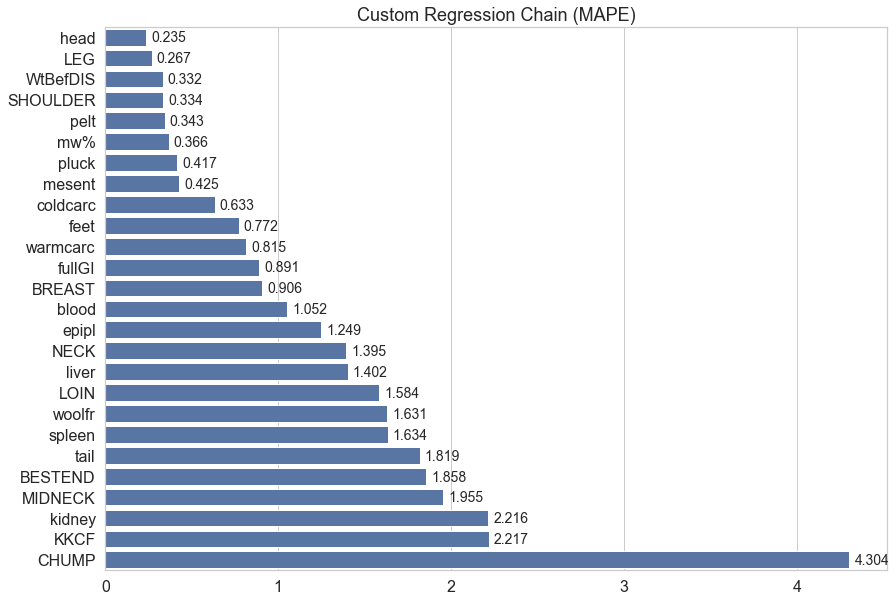

In [10]:
chain_links_4 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),
    (MultiOutputRegressor(xgb_reg), ['NECK', 'LEG', 'BREAST', 'BESTEND']),
    (MultiOutputRegressor(xgb_reg), ['CHUMP', 'pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['pluck', 'LOIN']),
    (MultiOutputRegressor(xgb_reg), ['feet']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['woolfr', 'blood', 'spleen', 'head', 'tail', 'MIDNECK']),
    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'KKCF', 'mw%']),
]

# Run Chain Regressor & show results
chain_reg = ChainRegressor(chain_links_4)
clinks = chain_reg.fit(X_train, y_train)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print_avg_scores(scores, 'Custom Chain Regressor Based on Feature Importances #4')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Custom Regression Chain (MAPE)')

* Μεταφέροντας το NECK πιό ψηλά στην αλυσίδα, πετύχαμε μια μικρή μείωση του μέσου σφάλματος η οποία ωοφείλεται κυρίως
στη μεγάλη μείωση τους σφάλματος του NECK.

### Περαιτέρω Διάσπαση της αλυσίδας
Στις δοκιμές που κάναμε παραπάνω, στο 4ο στάδιο της αλυσίδας οι μεταβλητές BREAST, LEG, NECK και BESTEND προβέπονται
παράλληλα με αποτέλεσμα να μην αξιοποιούνται οι μεταξύ τους συσχετίσεις που γνωρίζουμε πως υπάρχουν.
Προκειμένου λοιπόν να εκμεταλλευτούμε αυτές τις συσχετίσεις θα δοκιμάσουμε να τις υπολογίσουμε ακολουθιακά σε
διαφορετικά στάδια της αλυσίδας.

Custom Chain Regressor Based on Feature Importances #5
R2 score: 0.8211419714387903
MAE: 0.21662204634476823
RMSE: 0.3090731571132537
MAPE: 1.110368028275712



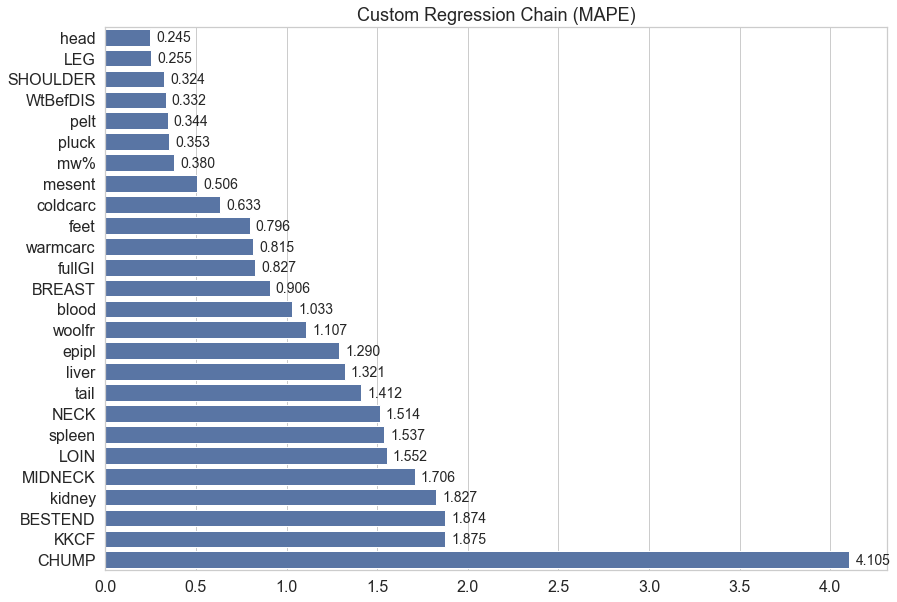

In [11]:
chain_links_5 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),
    (MultiOutputRegressor(xgb_reg), ['BREAST']),
    (MultiOutputRegressor(xgb_reg), ['LEG']),
    (MultiOutputRegressor(xgb_reg), ['NECK']),
    (MultiOutputRegressor(xgb_reg), ['BESTEND']),
    (MultiOutputRegressor(xgb_reg), ['CHUMP', 'pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['pluck', 'LOIN']),
    (MultiOutputRegressor(xgb_reg), ['feet']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['woolfr', 'blood', 'spleen', 'head', 'tail', 'MIDNECK']),
    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'KKCF', 'mw%']),

]

# Run Chain Regressor & show results
chain_reg = ChainRegressor(chain_links_5)
clinks = chain_reg.fit(X_train, y_train)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print_avg_scores(scores, 'Custom Chain Regressor Based on Feature Importances #5')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Custom Regression Chain (MAPE)')

Πράγματι, η εκμετάλλευση των συσχετίσων μεταξύ των μεταβλητών που αναφέραμε στην αλυσίδα είχε ως αποτέλεσμα τη μείωση
του σφάλματος.

### Χαρακτηριστικό "CHUMP"
Παρατηρήσαμε πως το χαρ/κο CHUMP έχει πολύ υψηλό σφάλμα και μάλιστα υπολογίζεται σε σχετικά αρχικό στάδιο της αλυσίδας,
με αποτέλεσμα να επηρεάζει αρνητικά τις επόμενες προβλέψεις. Για το λόγο αυτό, θα δοκιμάσουμε να μεταφέρουμε τη πρόβλεψή
του στο τέλος της αλυσίδας.

Custom Chain Regressor Based on Feature Importances #6
R2 score: 0.8208597515102608
MAE: 0.21996187468669545
RMSE: 0.31013120210533346
MAPE: 1.0343198747582147



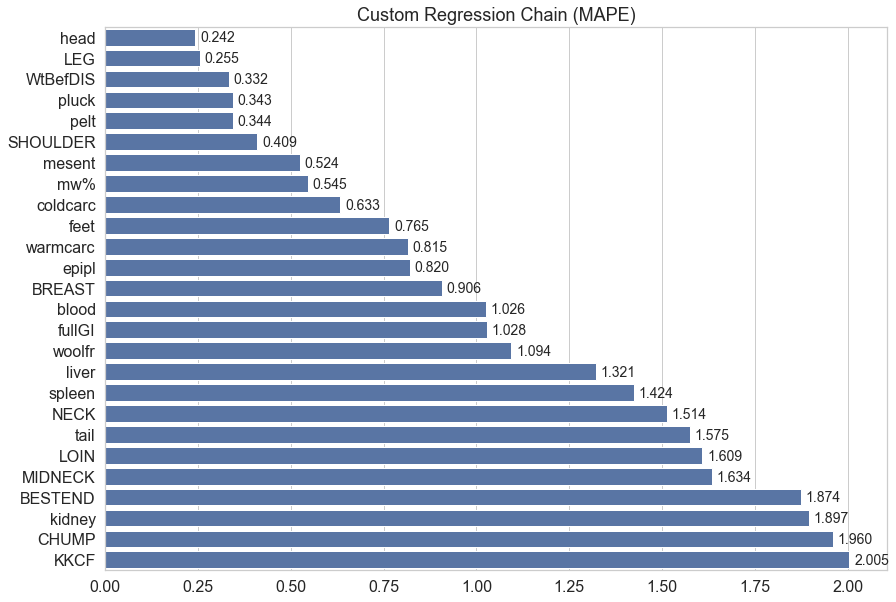

In [25]:
chain_links_6 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),
    (MultiOutputRegressor(xgb_reg), ['BREAST']),
    (MultiOutputRegressor(xgb_reg), ['LEG']),
    (MultiOutputRegressor(xgb_reg), ['NECK']),
    (MultiOutputRegressor(xgb_reg), ['BESTEND']),
    (MultiOutputRegressor(xgb_reg), ['pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['pluck', 'LOIN']),
    (MultiOutputRegressor(xgb_reg), ['feet']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['woolfr', 'blood', 'spleen', 'head', 'tail', 'MIDNECK']),
    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'mw%']),
    (LinearRegression(), ['CHUMP']),
    (LinearRegression(), ['KKCF']),
]

# Run Chain Regressor & show results
chain_reg = ChainRegressor(chain_links_6)
clinks = chain_reg.fit(X_train, y_train)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print_avg_scores(scores, 'Custom Chain Regressor Based on Feature Importances #6')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Custom Regression Chain (MAPE)', annot_dist=0.06)


* Παρατηρούμε ότι βάζοντας το CHUMP στο τέλος της αλυσίδας και χρησμοποιώντας linear regression αντι XGBoost, το MAPE
πράγματι μειώνεται περίπου στο μισό για το CHUMP ενώ οι περισσότερες απο τις υπόλοιπες μεταβλητές επηρεάζονται λίγο με
κάποιες να παρουσιάζουν μειωμένο MAPE και κάποιες αυξημένο.

* Ωστόσο, παρά τη μείωση που παρατηρείται στο MAPE, οι υπόλοιπες μετρικές του σφάλματος (MAE, RMSE) αυξάνονται ελαφρώς
και το R2 score μειώνεται αντίστοιχα.

# Data Binning

Θα χωρίσουμε τα δεδομένα σε buckets με βάση το χαρακτηριστικό "slweight(g)" ώστε να χαρακτηρίσουμε κάθε στοιχείο του
συνόλου δεδομένων ως "lightweight"(0), "middlewight"(1) και "heavyweight"(2).

In [13]:
from sklearn.preprocessing import KBinsDiscretizer
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Descretize data in 3 groups (buckets).
enc = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
data_binned = enc.fit_transform(data[['slweight(g)']])

# data_binned

## Εκπαίδευση Chain Regressor για κάθε Bucket ξεχωριστά

In [14]:
# Get indices of descretized data
bucket_1_idx = np.where(data_binned == 0)
bucket_2_idx = np.where(data_binned == 1)
bucket_3_idx = np.where(data_binned == 2)

# Separate data to buckets
bucket_1 = data.loc[bucket_1_idx[0], :]
bucket_2 = data.loc[bucket_2_idx[0], :]
bucket_3 = data.loc[bucket_3_idx[0], :]

# Describe
bucket_1[['slweight(g)']].describe()
bucket_2[['slweight(g)']].describe()
bucket_3[['slweight(g)']].describe()


,slweight(g)
count,40.000000
mean,15118.250000
std,2902.255964
min,9500.000000
25%,13274.750000
50%,14749.500000
75%,17899.000000
max,19200.000000


,slweight(g)
count,39.000000
mean,26838.128205
std,4783.377238
min,19399.000000
25%,24449.500000
50%,25600.000000
75%,29949.500000
max,35599.000000


,slweight(g)
count,40.000000
mean,48837.175000
std,10593.196818
min,35700.000000
25%,39074.250000
50%,49250.000000
75%,55924.750000
max,71599.000000


* Παραπάνω, χωρίσαμε τα δεδομένα σε 3 buckets με βάση τη μεταβλητή εισόδου "slweight(g)" - δηλαδή το βάρος του ζώου.
* Κάθε bucket περιέχει ίδιο αριθμό δειγμάτων.
* Το πρώτο bucket περιέχει τα τα στοιχεία με το μικρότερο βάρος που θα μπορούσαν να χαρακτηριστούν ώς
"Μικρού βάρους(lightweight)".
* Το δεύτερο bucket περιέχει τα τα στοιχεία με λίγο μεγαλύτερο βάρος που θα μπορούσαν να χαρακτηριστούν ώς
"Μεσαίου Βάρους(middleweight)".
* Το τρίτο bucket περιέχει τα τα στοιχεία με το μεγαλύτερο βάρος που θα μπορούσαν να χαρακτηριστούν ώς
"Μεγάλου βάρους(heavyweight)".

In [15]:
# Prepare data
X1, y1 = scale_split_labels(bucket_1)
X2, y2 = scale_split_labels(bucket_2)
X3, y3 = scale_split_labels(bucket_3)
X1_train, X1_test, y1_train, y1_test = split_train_test(X1, y1, test_size=0.15)
X2_train, X2_test, y2_train, y2_test = split_train_test(X2, y2, test_size=0.15)
X3_train, X3_test, y3_train, y3_test = split_train_test(X3, y3, test_size=0.15)

In [16]:
# Run Chain Regressor for 1st bucket
chain_reg = ChainRegressor(chain_links_6)
clinks = chain_reg.fit(X1_train, y1_train)
scores1 = mo_reg_scorer(chain_reg, X1_test, y1_test)

# Run Chain Regressor for 2nd bucket
chain_reg = ChainRegressor(chain_links_6)
clinks = chain_reg.fit(X2_train, y2_train)
scores2 = mo_reg_scorer(chain_reg, X2_test, y2_test)

# Run Chain Regressor for 3rd bucket
chain_reg = ChainRegressor(chain_links_6)
clinks = chain_reg.fit(X3_train, y3_train)
scores3 = mo_reg_scorer(chain_reg, X3_test, y3_test)

Custom Chain Regressor - 1st Bucket
R2 score: -0.4139146931402063
MAE: 0.7520548489681057
RMSE: 0.9100909133226414
MAPE: 32.92862250747783



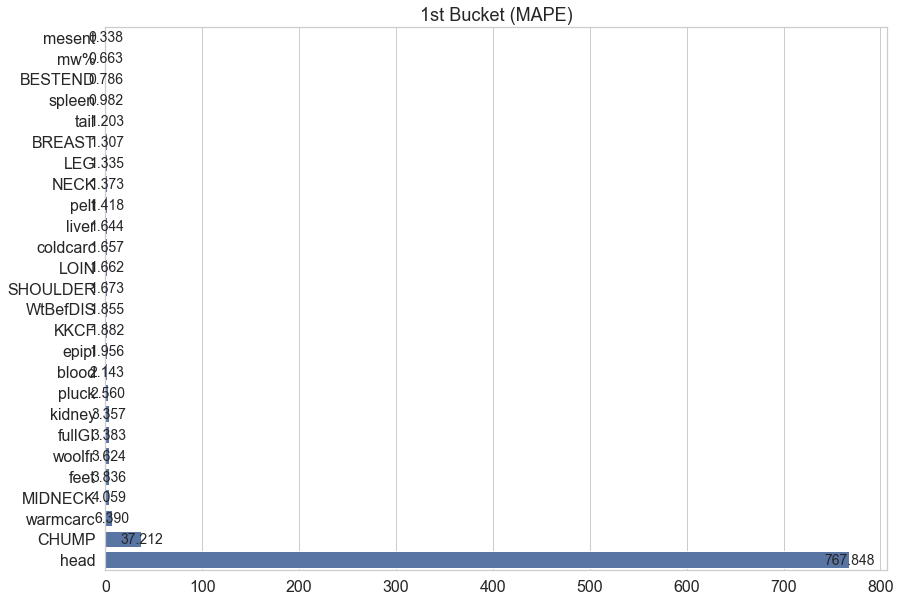

Custom Chain Regressor - 2nd Bucket
R2 score: 0.21246958442237793
MAE: 0.47268833980277974
RMSE: 0.6014913464310871
MAPE: 1.5907063133054176



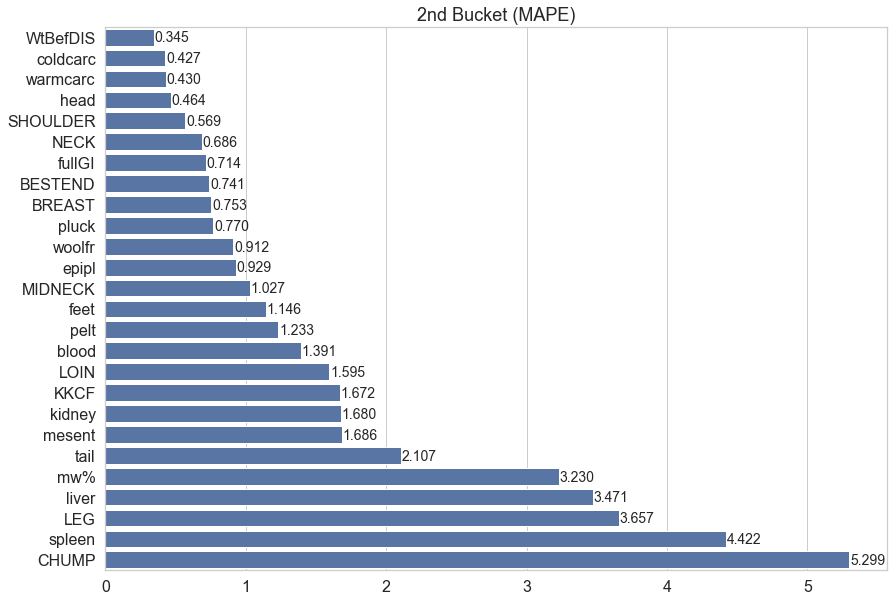

Custom Chain Regressor - 3rd Bucket
R2 score: 0.14783418814753166
MAE: 0.4644409383540931
RMSE: 0.5892446960030745
MAPE: 1.887027382651741



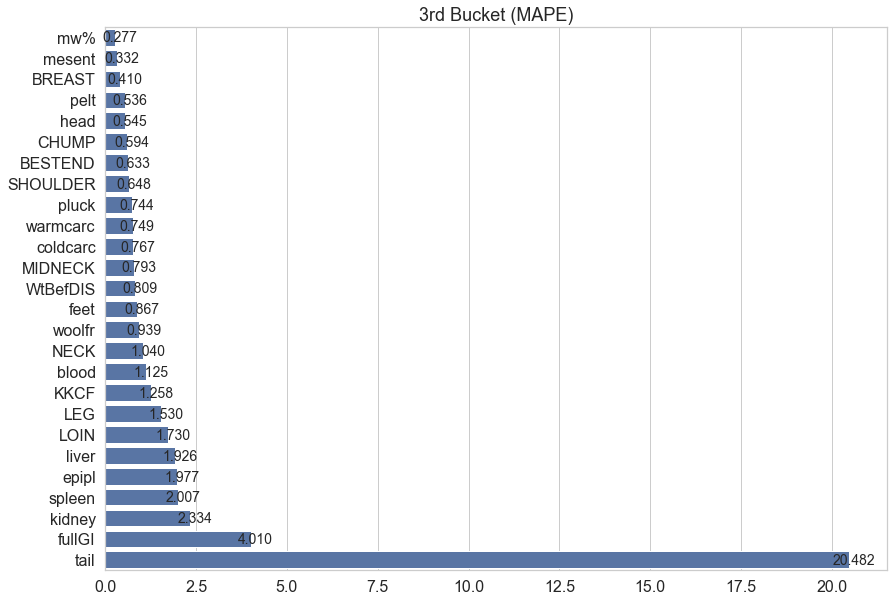

In [17]:
# Present results for each bucket
print_avg_scores(scores1, 'Custom Chain Regressor - 1st Bucket')
scores_barplot(scores1['rv_scores_mape'], y_test.columns, title='1st Bucket (MAPE)')

print_avg_scores(scores2, 'Custom Chain Regressor - 2nd Bucket')
scores_barplot(scores2['rv_scores_mape'], y_test.columns, title='2nd Bucket (MAPE)')

print_avg_scores(scores3, 'Custom Chain Regressor - 3rd Bucket')
scores_barplot(scores3['rv_scores_mape'], y_test.columns, title='3rd Bucket (MAPE)')

Προφανώς τα δεδομένα σε κάθε bucket είναι πολύ λίγα για να για να εκπαιδευτεί και να αξιολογηθεί κάπιο μοντέλο μηχανικής
μάθησης σε αυτά.

## Εισαγωγή Διακριτοποίησης Βάρους Ως Νέο Χαρακτηριστικό

Αφού έχουμε διακριτοποιήσει τα δεδομένα σε buckets με βάση το "slweight(g)" θα δοκιμάσουμε να χρησιμοποιήσουμε την
πληροφορία αυτή ως ενα επιπλέον χαρ/κο με βάση το οποίο θα προσπαθήσουμε τα διαχωρίσουμε τα train-test sets σε ποιό
αντιπροσωπευτικά δείγματα.

In [18]:
# Scale data & split targets from features
XX, yy = scale_split_labels(data)
# Add weight class we got from descretization as new column
XX['weight_class'] = [int(item) for item in data_binned.ravel().tolist()]
# Stratified train-test split
XX_train, XX_test, yy_train, yy_test = split_train_test(XX, yy,
                                                        test_size=0.2, strat=XX['weight_class'])

# XX_train.drop(['weight_class'], axis=1, inplace=True)
# XX_test.drop(['weight_class'], axis=1, inplace=True)

### Run #1

Custom Chain Regressor #6 - Stratified Split
R2 score: 0.8877332239988605
MAE: 0.21470797587540746
RMSE: 0.29001671911160465
MAPE: 1.1552220190441822



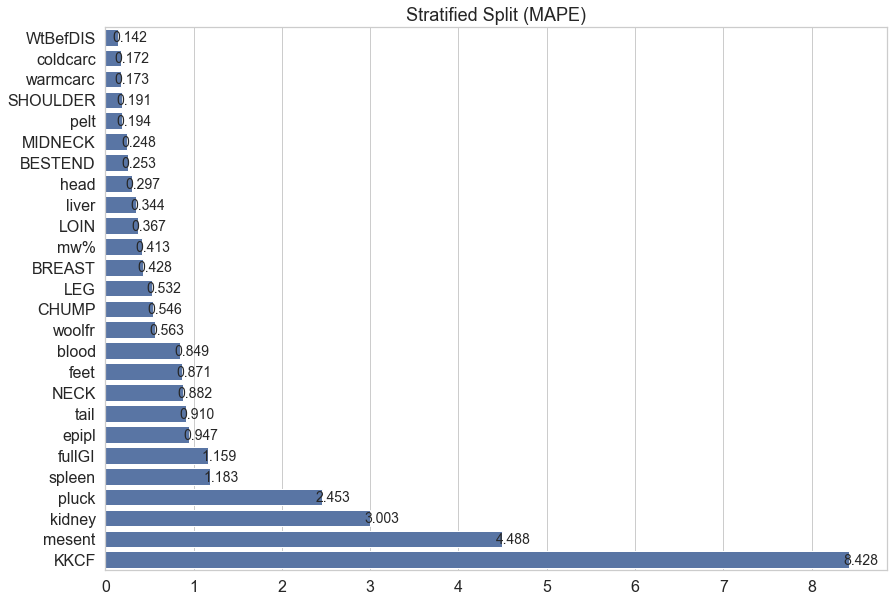

In [19]:
# Run Chain Regressor
chain_reg = ChainRegressor(chain_links_6)
clinks = chain_reg.fit(XX_train, yy_train)
scores_strat = mo_reg_scorer(chain_reg, XX_test, yy_test)
print_avg_scores(scores_strat, 'Custom Chain Regressor #6 - Stratified Split')
scores_barplot(scores_strat['rv_scores_mape'], y_test.columns, title='Stratified Split (MAPE)')

* Αν και το MAPE ανέβηκε με το stratification, ρίχνοντας μια πιό κοντινή ματιά παρατηρούμε πως το MAPE των περισσότερων
μεταβλητών μειώθηκε αισθητά.
* Ωστόσο κάποιες μεταβλητές (pluck, kidney, mesent) παρουσιάζουν πολύ υψηλότερο σφάλμα σε σχέση με πρίν το stratification.
* Τώρα που έχουμε πλέον έναν πιο αντιπροσωπευτικό διαχωρισμό των δεδομένων θα επανεξετάσουμε τη σειρά της αλυσίδας μήπως
 και μπορέσουμε να μειώσουμε τα αυξημένα σφάλματα και κατ' επέκταση το μέσο σφάλμα.

### Run #2

Custom Chain Regressor #1 - Stratified Split
R2 score: 0.9014323510734299
MAE: 0.1991810661820965
RMSE: 0.27092784846514345
MAPE: 0.9539291616802659



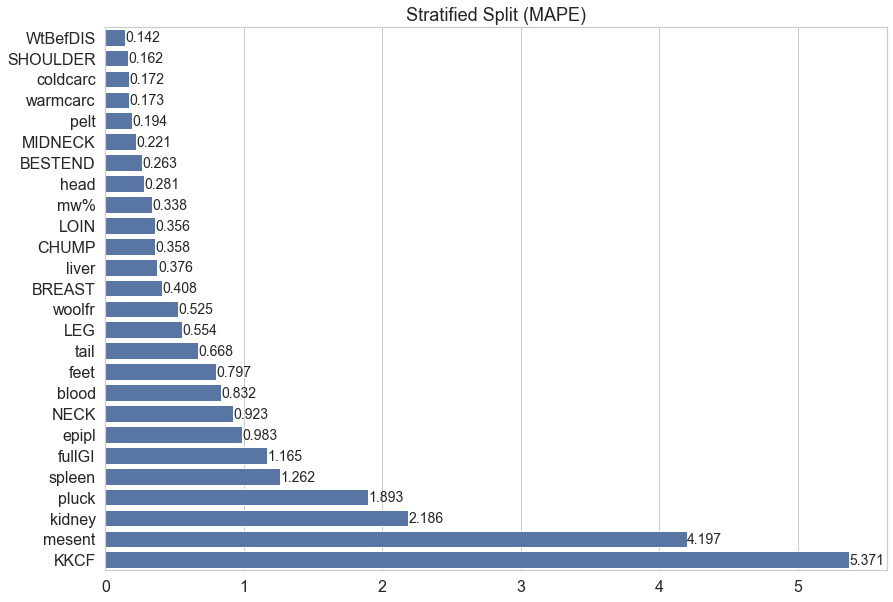

In [20]:
# Run Chain Regressor
chain_reg = ChainRegressor(chain_links_1)
clinks = chain_reg.fit(XX_train, yy_train)
scores_strat_1 = mo_reg_scorer(chain_reg, XX_test, yy_test)
print_avg_scores(scores_strat_1, 'Custom Chain Regressor #1 - Stratified Split')
scores_barplot(scores_strat_1['rv_scores_mape'], y_test.columns, title='Stratified Split (MAPE)')

* Παρά το γεγονός ότι η αλυσίδα 6 είχε το μικρότερο μέσο σφάλμα, παρατηρούμε πως η αλυσίδα 1 έχει πλέον μικρότερο σφάλμα
μετά το stratified split. Αυτό ίσως οφείλεται στο ότι η αλυσίδα 1 ακολουθεί πιό πιστά τα feature importances τα οποία
μετα το stratification ίσως είναι πιό αξιόπιστα αφού πλέον έχουμε έναν πιο αντιπροσωπευτικό διαχωρισμό των δεδομένων.
* Ίσως οι αλλαγές μου κάναμε και καταλήξαμε στην αλυσίδα 6 αφορούσαν μόνο το λιγότερο αντιπροσψποευκτικό
(και τυχαίο) διαχωρισμό που είχαμε πρίν το stratification.
* Επομένως, θα ξεκινήσουμε με την αλυσίδα 1 και θα κάνουμε κάποιες αλλαγές προκειμένου να μειώσουμε και αλλο το σφάλμα.

### Run #3

Custom Chain Regressor #7 - Stratified Split
R2 score: 0.8878181259851622
MAE: 0.21116753226087326
RMSE: 0.28666399094104994
MAPE: 0.8536729614520009



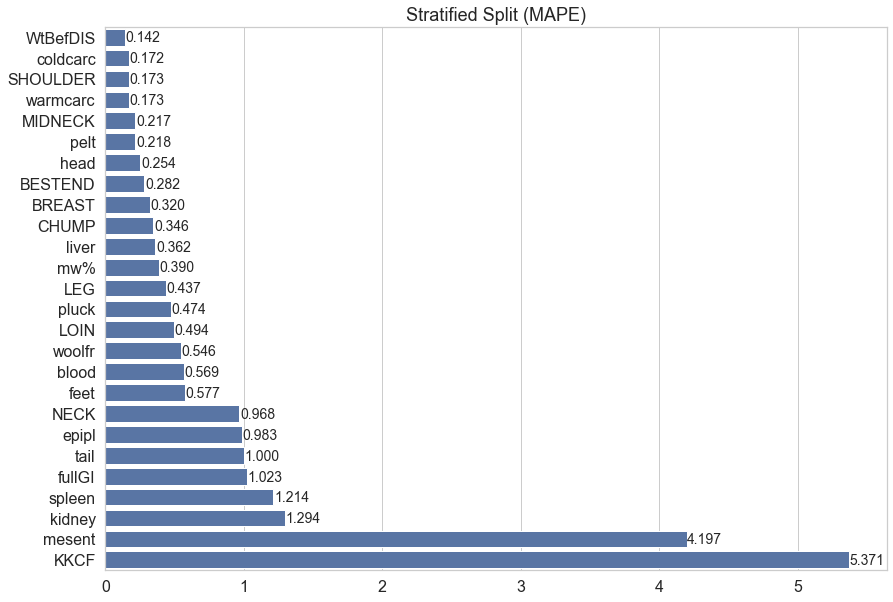

In [21]:
chain_links_7 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),
    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'KKCF']),
    (LinearRegression(), ['LEG', 'BREAST', 'BESTEND']),
    (LinearRegression(), ['pluck']),
    (LinearRegression(), ['CHUMP', 'woolfr', 'MIDNECK', 'pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'NECK', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['LOIN', 'head', 'tail']),
    (MultiOutputRegressor(xgb_reg), ['feet', 'blood', 'spleen']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['mw%']),
]

# Run Chain Regressor
chain_reg = ChainRegressor(chain_links_7)
clinks = chain_reg.fit(XX_train, yy_train)
scores_strat_2 = mo_reg_scorer(chain_reg, XX_test, yy_test)
print_avg_scores(scores_strat_2, 'Custom Chain Regressor #7 - Stratified Split')
scores_barplot(scores_strat_2['rv_scores_mape'], y_test.columns, title='Stratified Split (MAPE)')

### Run #4
Ας δοκιμάσουμε και πάλι να αφήσουμε τα χαρακτηριστικά που δεν επηρρεάζουν άλλα χαρ/κα στο τέλος της αλυσίδας.

Custom Chain Regressor #8 - Stratified Split
R2 score: 0.8982153445206887
MAE: 0.20460925624503284
RMSE: 0.2730366942818722
MAPE: 0.8085006938038949



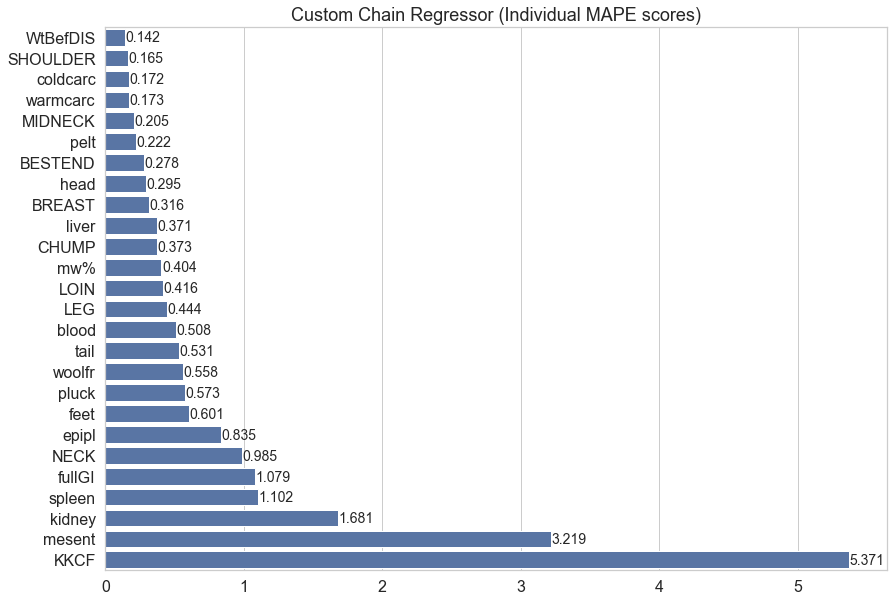

In [32]:
chain_links_8 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),
    (MultiOutputRegressor(xgb_reg), ['KKCF']),
    (LinearRegression(), ['epipl', 'mesent']),
    (LinearRegression(), ['LEG', 'BREAST', 'BESTEND']),
    (LinearRegression(), ['pluck']),
    (LinearRegression(), ['CHUMP', 'MIDNECK', 'pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'SHOULDER', 'NECK']),
    (MultiOutputRegressor(xgb_reg), ['LOIN', 'head']),
    (MultiOutputRegressor(xgb_reg), ['feet', 'blood',]),
    (MultiOutputRegressor(xgb_reg), ['fullGI', 'woolfr', 'spleen', 'tail']),
    (LinearRegression(), ['mw%']),

]

# Run Chain Regressor
chain_reg = ChainRegressor(chain_links_8)
clinks = chain_reg.fit(XX_train, yy_train)
scores_strat_3 = mo_reg_scorer(chain_reg, XX_test, yy_test)
print_avg_scores(scores_strat_3, 'Custom Chain Regressor #8 - Stratified Split')
scores_barplot(scores_strat_3['rv_scores_mape'], y_test.columns, title='Custom Chain Regressor (Individual MAPE scores)')

* Παρατηρούμε ότι το μέσο MAPE μειώθηκε.
* Επίσης μειώσαμε το μέσο MAPE λίγο ακόμα επιστρέφοντας κάποια απο τα μή-σημαντικά χαρ/κα στη αρχική τους θέση.
